# PCA 迷你项目 
### 使用特征脸方法和 SVM 进行脸部识别
我们在讨论 PCA 时花了很长的时间讨论理论问题，因此，在此迷你项目中，我们将请你研究一些 sklearn 代码。特征脸代码很有趣并且很丰富，足以当做此迷你项目的实验台。



注意：
在此示例中使用的数据集来自“[Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/)”，亦称为 [LFW_ Download](http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz) (233MB) 并经过预处理。这是[原始数据](http://scikit-learn.org/0.15/auto_examples/applications/face_recognition.html)。

In [1]:

from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import PCA
from sklearn.svm import SVC

## 加载数据集

In [2]:
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people('data', min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)


# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print( "n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


### 拆分为训练集和测试集

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## 计算 PCA

我们现在可以对脸部数据集（当做无标签数据集）计算 [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)（特征脸）了：无监督式特征提取/降维。

In [49]:
n_components = 150

print( "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]) )
t0 = time()

# TODO: Create an instance of PCA, initializing with n_components=n_components and whiten=True
pca = PCA(n_components=n_components, whiten=True, svd_solver='randomized')

#TODO: pass the training dataset (X_train) to pca's 'fit()' method
pca = pca.fit(X_train)


print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 966 faces
done in 0.190s


将输入数据投射到特征脸标准正交基

In [50]:
eigenfaces = pca.components_.reshape((n_components, h, w))

t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


done in 0.032s


## 训练 SVM 分类模型

我们将 [SVM 分类器](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)拟合到训练集中。我们将使用 [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) 为该分类器找到一组合适的参数。

In [51]:

param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }

# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)

print("Best estimator found by grid search:")
print(clf.best_estimator_)

Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


## 用测试集评估模型质量

#### 1. 分类报告
训练好分类器后，我们在测试数据集上运行该分类器，并定性地评估结果。Sklearn 的[分类报告](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)显示了每个类别的一些主要分类指标。

In [52]:
y_pred = clf.predict(X_test_pca)

print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.60      0.69      0.64        13
     Colin Powell       0.76      0.90      0.82        60
  Donald Rumsfeld       0.71      0.74      0.73        27
    George W Bush       0.90      0.88      0.89       146
Gerhard Schroeder       0.86      0.76      0.81        25
      Hugo Chavez       0.90      0.60      0.72        15
       Tony Blair       0.85      0.78      0.81        36

      avg / total       0.84      0.83      0.83       322



#### 2. 混淆矩阵

查看分类器效果的另一种方式是查看[混淆矩阵](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)。为此，我们可以直接调用 [sklearn.metrics.confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)：

In [9]:
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

[[  9   0   3   1   0   0   0]
 [  2  52   1   4   0   1   0]
 [  4   0  22   1   0   0   0]
 [  1  11   2 127   3   1   1]
 [  0   2   0   1  19   1   2]
 [  0   3   0   1   2   8   1]
 [  0   2   1   2   1   0  30]]


#### 3. 绘制最显著的特征脸

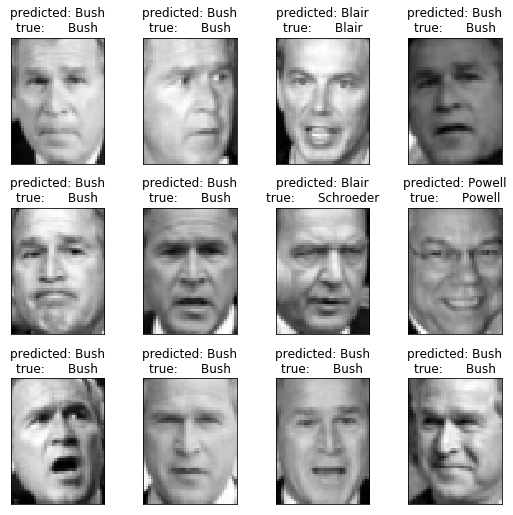

In [10]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())



# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return ('predicted: %s\ntrue:      %s' % (pred_name, true_name))

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

pl.show()

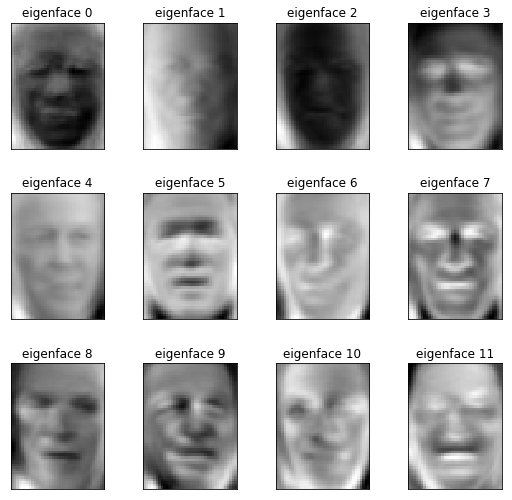

In [11]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()

## 练习：每个主成分的可释方差

我们提到 PCA 将对主成分排序，第一个主成分会显示最大方差的方向，第二个主成分具有第二大方差，等等。第一个主成分解释了多少方差？第二个呢？
打印pca.explained_variance_ratio_，第一主成分解释了19%方差，第二主成分解释了15%方差
该数据主要说明主成分变动对方差的影响，例如：2x+3b=y,x和b是特征，取值范围都是0-1，x从0到1，y变化了多少。



## 练习：要使用多少个主成分？

现在你将实验不同数量的主成分。在多类别分类问题（例如此问题，要应用 2 个以上的标签）中，准确率指标没有二类别问题的准确率指标直观。相反，我们将使用一个热门指标，即 F1 分数。

我们将在关于评估指标的课程中深入了解 F1 分数，但是你自己将明白好的分类器的 F1 分数是高还是低。你将通过改变主成分的数量，观察 F1 分数会如何变化。

当你添加更多主成分（作为特征）来训练分类器时，你认为分类器的效果会更好还是更差？
当主成分较少时，添加主成分，会使F1分数提高，但当主成分增加到一定数量时，F1分数会下降。

## 练习：F1 分数与所使用的主成分数量

将 n_components 更改为以下值：[10、15、25、50、100、250]。对于每个主成分数量，注意 Ariel Sharon 的 F1 分数。（对于 10 个主成分，代码中的绘制函数将崩溃，但是你应该能够看到 F1 分数。）如果你看到更高的 F1 分数，是否意味着分类器的效果更好或更差？
n_components=10
                    precision    recall  f1-score   support

     Ariel Sharon       0.10      0.15      0.12        13
     Colin Powell       0.43      0.53      0.48        60
  Donald Rumsfeld       0.26      0.33      0.30        27
    George W Bush       0.66      0.58      0.62       146
Gerhard Schroeder       0.17      0.20      0.18        25
      Hugo Chavez       0.25      0.13      0.17        15
       Tony Blair       0.50      0.39      0.44        36

      avg / total       0.49      0.46      0.47       322
      
n_components=15
                      precision    recall  f1-score   support

     Ariel Sharon       0.25      0.46      0.32        13
     Colin Powell       0.64      0.72      0.68        60
  Donald Rumsfeld       0.46      0.63      0.53        27
    George W Bush       0.82      0.68      0.74       146
Gerhard Schroeder       0.39      0.44      0.42        25
      Hugo Chavez       0.60      0.40      0.48        15
       Tony Blair       0.50      0.50      0.50        36

      avg / total       0.66      0.62      0.63       322

n_components=25
                   precision    recall  f1-score   support

     Ariel Sharon       0.56      0.69      0.62        13
     Colin Powell       0.72      0.87      0.79        60
  Donald Rumsfeld       0.48      0.52      0.50        27
    George W Bush       0.86      0.82      0.84       146
Gerhard Schroeder       0.56      0.56      0.56        25
      Hugo Chavez       0.89      0.53      0.67        15
       Tony Blair       0.70      0.64      0.67        36

      avg / total       0.75      0.74      0.74       322

n_components=50
                   precision    recall  f1-score   support

     Ariel Sharon       0.62      0.77      0.69        13
     Colin Powell       0.83      0.92      0.87        60
  Donald Rumsfeld       0.68      0.56      0.61        27
    George W Bush       0.86      0.90      0.88       146
Gerhard Schroeder       0.74      0.68      0.71        25
      Hugo Chavez       0.77      0.67      0.71        15
       Tony Blair       0.83      0.67      0.74        36

      avg / total       0.81      0.82      0.81       322

n_components=100
                    precision    recall  f1-score   support

     Ariel Sharon       0.64      0.69      0.67        13
     Colin Powell       0.82      0.90      0.86        60
  Donald Rumsfeld       0.75      0.67      0.71        27
    George W Bush       0.89      0.95      0.92       146
Gerhard Schroeder       0.82      0.72      0.77        25
      Hugo Chavez       0.90      0.60      0.72        15
       Tony Blair       0.90      0.78      0.84        36

      avg / total       0.85      0.85      0.85       322

n_components=150
                     precision    recall  f1-score   support

     Ariel Sharon       0.56      0.69      0.62        13
     Colin Powell       0.74      0.87      0.80        60
  Donald Rumsfeld       0.76      0.81      0.79        27
    George W Bush       0.93      0.87      0.90       146
Gerhard Schroeder       0.76      0.76      0.76        25
      Hugo Chavez       0.73      0.53      0.62        15
       Tony Blair       0.88      0.83      0.86        36

      avg / total       0.84      0.83      0.83       322
      
n_components=250
                     precision    recall  f1-score   support

     Ariel Sharon       0.55      0.85      0.67        13
     Colin Powell       0.76      0.90      0.82        60
  Donald Rumsfeld       0.81      0.63      0.71        27
    George W Bush       0.94      0.89      0.91       146
Gerhard Schroeder       0.77      0.80      0.78        25
      Hugo Chavez       0.78      0.47      0.58        15
       Tony Blair       0.81      0.81      0.81        36

      avg / total       0.84      0.83      0.83       322
      
n_components=500
                     precision    recall  f1-score   support

     Ariel Sharon       0.43      0.69      0.53        13
     Colin Powell       0.63      0.87      0.73        60
  Donald Rumsfeld       0.59      0.63      0.61        27
    George W Bush       0.87      0.75      0.80       146
Gerhard Schroeder       0.59      0.40      0.48        25
      Hugo Chavez       0.62      0.53      0.57        15
       Tony Blair       0.71      0.67      0.69        36

      avg / total       0.73      0.71      0.71       322

n_components=966
                    precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        13
     Colin Powell       0.00      0.00      0.00        60
  Donald Rumsfeld       0.00      0.00      0.00        27
    George W Bush       0.45      0.99      0.62       146
Gerhard Schroeder       0.00      0.00      0.00        25
      Hugo Chavez       0.00      0.00      0.00        15
       Tony Blair       0.00      0.00      0.00        36

      avg / total       0.21      0.45      0.28       322

## 练习：降维和过拟合
在使用很高数量的主成分时，是否看到任何过拟合现象？在这种情况下，PCA 降维是否能够改善效果？
使用高数量的主成分时，准确率会降低，可能和成分之间相互依赖关系有关，不一定是过拟合，通过PCA降维，能很好的改善效果

In [14]:
pca.explained_variance_ratio_

array([0.19346537, 0.15116845, 0.07083675, 0.05951796, 0.05157502,
       0.02887156, 0.02514484, 0.02176463, 0.02019379, 0.01902124,
       0.01682214, 0.01580598, 0.01223363, 0.01087937, 0.01064451,
       0.00979653, 0.00892398, 0.00854845, 0.00835711, 0.00722635,
       0.00696569, 0.00653856, 0.00639558, 0.00561316, 0.00531107,
       0.00520152, 0.00507466, 0.00484209, 0.00443587, 0.00417829,
       0.00393705, 0.00381728, 0.00356061, 0.00351201, 0.00334556,
       0.00329931, 0.00314626, 0.00296217, 0.00290136, 0.00284722,
       0.00280004, 0.00267556, 0.00259901, 0.00258401, 0.00240919,
       0.00238995, 0.00235403, 0.00222587, 0.00217507, 0.00216566,
       0.00209064, 0.00205426, 0.00200422, 0.00197396, 0.0019383 ,
       0.00188764, 0.00180173, 0.00178897, 0.00174819, 0.00173054,
       0.00165647, 0.00162948, 0.00157409, 0.00153429, 0.00149965,
       0.00147262, 0.00143931, 0.00141882, 0.00139698, 0.00138147,
       0.00134005, 0.00133169, 0.00128812, 0.00125595, 0.00124